In [53]:
#Imports the libraries and read the data files

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os, sys, email
import gensim
from gensim.models import Doc2Vec
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from string import punctuation
import timeit
from sklearn.cluster import KMeans
from sklearn import metrics
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
start = timeit.default_timer()
import pandas as pd 

df = pd.DataFrame.from_csv('10K_sample.txt', sep='\t', header=0)

C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


In [54]:
df[['state','content']].groupby('state').count().reset_index()

,state,content
0,Arizona,3742
1,Arkansas,393
2,Louisiana,947
3,Mississippi,661
4,Nevada,1216
5,New Mexico,666
6,Tennessee,2070
7,Wyoming,304


In [55]:
df['date'] = df['date'].astype('datetime64[ns]')

In [56]:
df.date.describe()

count                   10000
unique                    259
top       2016-10-27 00:00:00
freq                       85
first     2016-09-06 00:00:00
last      2017-05-22 00:00:00
Name: date, dtype: object

In [64]:
from collections import Counter

df.content = df.content.astype(str)
df['word_cnt'] = df.content.str.split().str.len()

In [65]:
df.word_cnt.describe()

count     10000.000000
mean        400.455500
std        1418.530202
min           1.000000
25%         142.000000
50%         273.000000
75%         529.000000
max      112891.000000
Name: word_cnt, dtype: float64

In [77]:
len(df[df['word_cnt']>1000])

317

C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


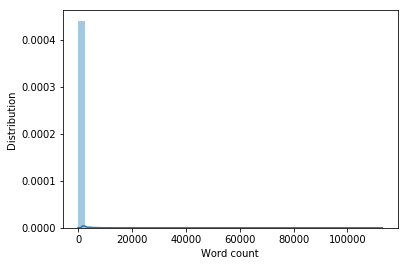

In [114]:
import seaborn as sns

ax = sns.distplot(df.word_cnt)
ax.set(xlabel='Word count', ylabel='Distribution')
plt.show()

In [116]:
df_filltered = df[(df['word_cnt']>0) & (df['word_cnt']<1000)]

C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


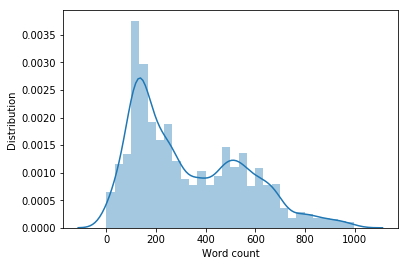

In [117]:
import seaborn as sns

ax = sns.distplot(df_filltered.word_cnt)
ax.set(xlabel='Word count', ylabel='Distribution')
plt.show()

In [66]:
df.head()

,state,id,link,county,newspaper,date,content,notice_id,word_cnt
320471,Arizona,29/12152016_23843750,http://www.publicnoticeads.com/AZ/search/view....,Maricopa,Arizona Business Gazette (Phoenix),2016-12-15,NOTICE (for publication) ARTICLES OF ORGANIZAT...,23843750.0,122
428137,Wyoming,3468/11152016_23781745,http://www.publicnoticeads.com/WY/search/view....,Natrona,Casper Star-Tribune,2016-11-15,ADVERTISEMENT FOR BIDS FOR FRONTIER MIDDLE SCH...,23781745.0,613
171469,Nevada,3371/10312016_23751825,http://www.publicnoticeads.com/NV/search/view....,Clark,Nevada Legal News,2016-10-27,NOTICE OF SALE APN: 177-21-310-169 Order No: H...,23751825.0,616
486209,Arizona,42/5172017_24138674,http://www.publicnoticeads.com/AZ/search/view....,Maricopa,Arizona Business Gazette (Phoenix),2017-05-18,NO. CV2017-00580 SUMMONS IN THE SUPERIOR COURT...,24138674.0,373
227894,Tennessee,2898/5122017_24128271,http://www.publicnoticeads.com/TN/search/view....,Davidson,"Tennessean, The (Nashville)",2017-05-12,0002131718 PUBLIC NOTICE The following vehicle...,24128271.0,189


In [3]:
# Convert to list
data = df.content.values.tolist()
# Remove new line characters
data = [str(sent).lower() for sent in data]

data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove single word number quotes
data = [re.sub("\d+.\d*", "", sent) for sent in data]

# Remove punctation
data = [re.sub("\!", "", sent) for sent in data]

# Remove blank 
temp = [x for x in data if x != '']

data = temp
print(data[:20])

['notice (for publication) articles of organization have been filed in the office of the arizona corporation commission for i name: cc solutions llc ii the address of the known place of business is: n. murray grey dr. queen creek, az the name and street address of the statutory agent is: claudia m. romero n. murray grey dr. queen creek, az iii (please check a or b) b. [x] management of the limited liability company is reserved to the members. the names and addresses of each person who is a member are: (please check appropriate box) claudia m. romero n. murray grey dr. queen creek, az [x] member [] manager published: dec.   jan.  ', 'advertisement for bids for frontier middle school drainage improvements for natrona county school district no. casper, wyoming notice is hereby given, pursuant to wyoming statute section - that the natrona county school district no.  casper, wyoming, will receive sealed bids until  am., local time, may   for the following: description of work: installation 

In [84]:
# Convert to list
def data_clean(data):
    # Remove new line characters
    data = [str(sent).lower() for sent in data]

    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    # Remove single word number quotes
    data = [re.sub("\d+.\d*", "", sent) for sent in data]

    # Remove punctation
    data = [re.sub("\!", "", sent) for sent in data]

    # Remove blank 
    temp = [x for x in data if x != '']

    data = temp
    return data

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['notice', 'for', 'publication', 'articles', 'of', 'organization', 'have', 'been', 'filed', 'in', 'the', 'office', 'of', 'the', 'arizona', 'corporation', 'commission', 'for', 'name', 'cc', 'solutions', 'llc', 'ii', 'the', 'address', 'of', 'the', 'known', 'place', 'of', 'business', 'is', 'murray', 'grey', 'dr', 'queen', 'creek', 'az', 'the', 'name', 'and', 'street', 'address', 'of', 'the', 'statutory', 'agent', 'is', 'claudia', 'romero', 'murray', 'grey', 'dr', 'queen', 'creek', 'az', 'iii', 'please', 'check', 'or', 'management', 'of', 'the', 'limited', 'liability', 'company', 'is', 'reserved', 'to', 'the', 'members', 'the', 'names', 'and', 'addresses', 'of', 'each', 'person', 'who', 'is', 'member', 'are', 'please', 'check', 'appropriate', 'box', 'claudia', 'romero', 'murray', 'grey', 'dr', 'queen', 'creek', 'az', 'member', 'manager', 'published', 'dec', 'jan']]


In [5]:
LabeledSentence = gensim.models.doc2vec.TaggedDocument

In [9]:
all_content = []
j = 0

for em in data_words:           
    all_content.append(LabeledSentence(em,[j]))
    j+=1

print("Number of non-empty emails vectors: ", j)

Number of non-empty emails vectors:  10000


In [10]:
print(all_content[278])

TaggedDocument(['notice', 'of', 'trustees', 'sale', 'file', 'id', 'flores', 'notice', 'is', 'hereby', 'given', 'that', 'leonard', 'mcdonald', 'attorney', 'at', 'law', 'as', 'trustee', 'or', 'successor', 'trustee', 'or', 'substituted', 'trustee', 'pursuant', 'to', 'the', 'deed', 'of', 'trust', 'which', 'had', 'an', 'original', 'balance', 'of', 'executed', 'by', 'manuel', 'flores', 'married', 'man', 'as', 'his', 'sole', 'and', 'separate', 'property', 'escobar', 'way', 'phoenix', 'az', 'dated', 'february', 'and', 'recorded', 'february', 'as', 'instrument', 'no', 'docket', 'page', 'of', 'official', 'records', 'in', 'the', 'office', 'of', 'the', 'county', 'recorder', 'of', 'maricopa', 'county', 'state', 'of', 'arizona', 'will', 'sell', 'the', 'real', 'property', 'described', 'herein', 'by', 'public', 'auction', 'on', 'may', 'at', 'at', 'the', 'main', 'entrance', 'to', 'the', 'superior', 'courts', 'building', 'at', 'the', 'maricopa', 'county', 'courthouse', 'jefferson', 'phoenix', 'az', 'to'

In [11]:
d2v_model = Doc2Vec(all_content, size = 2000, window = 10, min_count = 500, workers=7, dm = 1, 
                alpha=0.025, min_alpha=0.001)

C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [12]:
d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [13]:
# shows the similar docs with id = 99
print (d2v_model.docvecs.most_similar(1))
#print(all_content[282])
#print(all_content[1

[(9263, 0.9075719118118286), (2736, 0.7595829367637634), (9281, 0.7397918701171875), (3528, 0.7024680972099304), (7066, 0.6631973385810852), (1681, 0.6353466510772705), (1612, 0.6309569478034973), (4815, 0.6286769509315491), (5211, 0.6243445873260498), (7647, 0.6189743280410767)]


In [19]:
kmeans_model = KMeans(n_clusters=10, init='k-means++', max_iter=100)  
X = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)
labels=kmeans_model.labels_.tolist()


C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  


In [20]:
l = kmeans_model.fit_predict(d2v_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_model.docvecs.doctag_syn0)

C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """Entry point for launching an IPython kernel.
C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  
C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


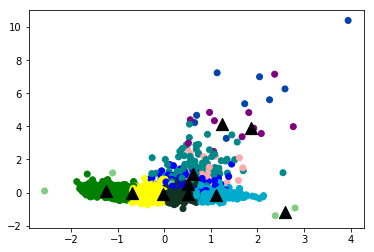

<Figure size 72x72 with 0 Axes>

In [30]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#FFAAAA",
          "#123321", "#008988", "#00ABCD", "#80CC80", "#0044AA",
         ]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [ ]:
stop = timeit.default_timer()
execution_time = stop - start

print(execution_time) #It returns time in sec